                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 2296
Model:                     ARMA(4, 0)   Log Likelihood                5317.983
Method:                       css-mle   S.D. of innovations              0.024
Date:                Wed, 22 Nov 2017   AIC                         -10623.966
Time:                        22:32:37   BIC                         -10589.532
Sample:                    08-11-2011   HQIC                        -10611.410
                         - 11-22-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0007      0.001     -0.772      0.440      -0.002       0.001
ar.L1.Adj Close     0.3324      0.021     15.874      0.000       0.291       0.373
ar.L2.Adj Close     0.1063      

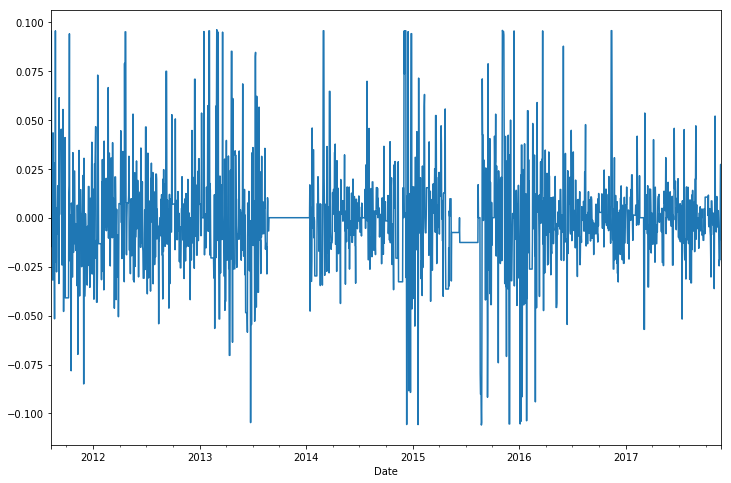

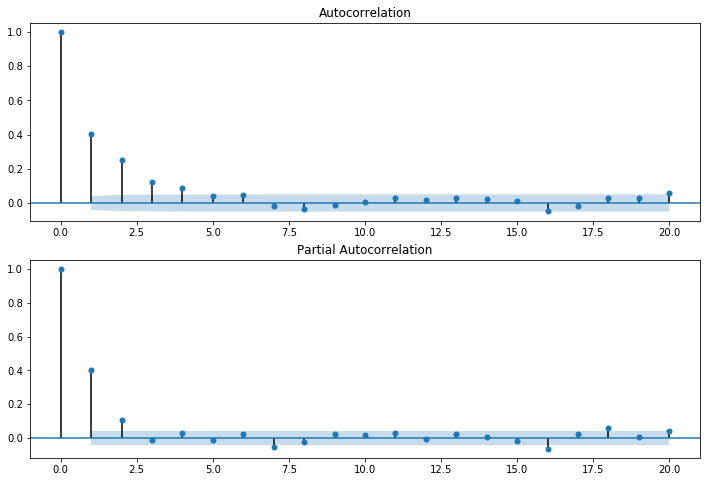

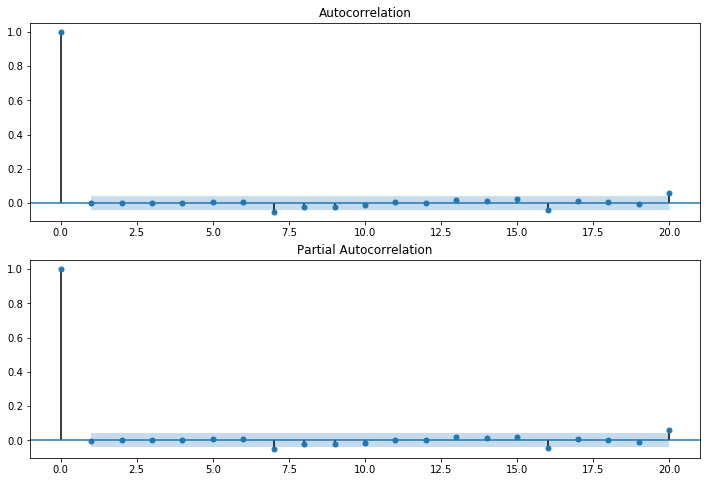

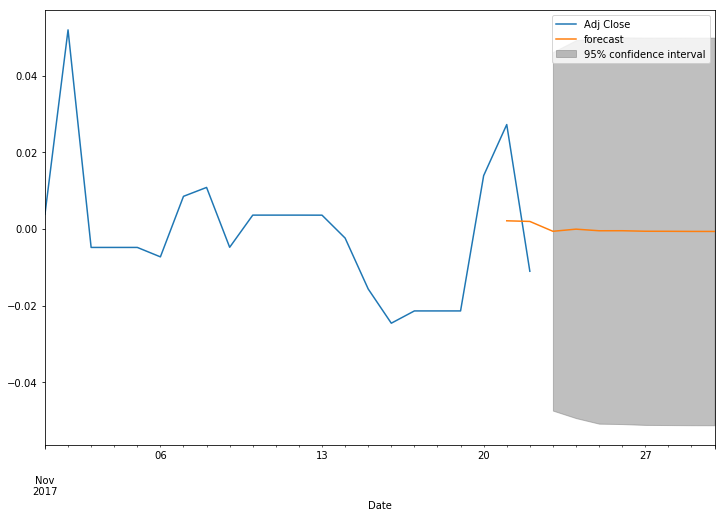

In [84]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
%matplotlib inline

#从yahoo读取方正证券的数据
Stock_Data = data.DataReader(name='601901.SS',data_source='yahoo',start='2000-1-1')

#求差分，设频率，填空值
Stock_diff = Stock_Data['Adj Close'].diff(1)
Stock_diff = Stock_diff[1:].asfreq('D')
Stock_diff = Stock_diff.fillna(method='ffill')

#求收益率图像，折线图
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot(111)
Stock_Ret = np.log(Stock_Data['Adj Close']/Stock_Data['Adj Close'].shift(1))
Stock_Ret = Stock_Ret[1:].asfreq('D')
Stock_Ret = Stock_Ret.fillna(method='ffill')
Stock_Ret.plot(ax=ax)


#先是识别ARMA模型阶次
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Stock_diff,lags=20,ax=ax1,)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Stock_diff,lags=20,ax=ax2)

#ARMA建模
#自相关图显示滞后有1,2,3,4超出了置信边界；
#偏相关图显示在滞后1，2阶时的偏自相关系数超出了置信边界
#选择合适的p和q，观察得到p，q分别为4,2
#建立ARMA(4,2)模型：即使得自相关和偏自相关都缩小至零,选择一个混合模型。
'''
但此出并没有选择将AR的最大阶为4，MA的最大阶为2，因为如果ARMA的阶数取4和2的时候，会抛出如下警告：
H:\python\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  即意思为 最大似然化未能收敛，所以不能采用
  
  然后我选择的ARMA的阶数取4和0，确保模型收敛
'''
arma_mod = sm.tsa.ARMA(Stock_Ret,(4,0)).fit()
print(arma_mod.summary())

#ARMA检验：对ARMA模型所产生的残差做自相关图，由图可见连续残差不存在自相关
resid = arma_mod.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=20, ax=ax2)

#向前预测多期
'''
   ax = Stock_Ret.ix['2017-11-22':].plot(ax=ax)这句话会抛出如下警告，不推荐使用ix

   H:\python\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: 
  .ix is deprecated. Please use
  .loc for label based indexing or
  .iloc for positional indexing
  
  根据提示推荐使用如下 ax = Stock_Ret.loc['2017-11-1':].plot(ax=ax)
  
'''
predict_stocks = arma_mod.predict('2017-11-22', '2017-11-30', dynamic=True)
fig, ax = plt.subplots(figsize=(12, 8))
ax = Stock_Ret.loc['2017-11-1':].plot(ax=ax)
fig = arma_mod.plot_predict('2017-11-21', '2017-11-30', dynamic=True, ax=ax, plot_insample=False)
